In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/courses/cse519/data/


/content/drive/MyDrive/courses/cse519/data


In [ ]:
import pandas as pd
df = pd.read_csv('jokes_with_language.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561550 entries, 0 to 561549
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   selftext     561547 non-null  object 
 1   title        561505 non-null  object 
 2   score        561488 non-null  float64
 3   created_utc  561488 non-null  float64
 4   joke_text    561488 non-null  object 
 5   language     561471 non-null  object 
dtypes: float64(2), object(4)
memory usage: 25.7+ MB


In [ ]:
df_filtered = df[(df['language'] == 'en') & (df['joke_text'].notnull())].copy()
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 558509 entries, 0 to 561549
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   selftext     558508 non-null  object 
 1   title        558509 non-null  object 
 2   score        558509 non-null  float64
 3   created_utc  558509 non-null  float64
 4   joke_text    558509 non-null  object 
 5   language     558509 non-null  object 
dtypes: float64(2), object(4)
memory usage: 29.8+ MB


In [ ]:
!apt install nvidia-cuda-toolkit

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libaccinj64-11.5 libatk-wrapper-java libatk-wrapper-java-jni
  libbabeltrace1 libcub-dev libcublas11 libcublaslt11 libcudart11.0 libcufft10 libcufftw10
  libcuinj64-11.5 libcupti-dev libcupti-doc libcupti11.5 libcurand10 libcusolver11 libcusolvermg11
  libcusparse11 libdebuginfod-common libdebuginfod1 libegl-dev libfontenc1 libgail-common libgail18
  libgl-dev libgl1-mesa-dev libgles-dev libgles1 libglvnd-core-dev libglvnd-dev libglx-dev
  libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libipt2 libnppc11 libnppial11 libnppicc11 libnppidei11
  libnppif11 libnppig11 libnppim11 libnppist11 libnppisu11 libnppitc11 libnpps11 libnvblas11
  libnvidia-compute-495 libnvidia-compute-510 libnvidia-compute-535 libnvidia-ml-dev libnvjpeg11
  libnvrtc-builtins11.5 libnvrtc11.2 libnvtoolsext1 libnvvm4 libopengl-dev libr

In [ ]:
!conda install -c rapidsai -c nvidia -c conda-forge \
      rapids=23.10 \
      cudatoolkit=11.8

/bin/bash: line 1: conda: command not found


In [ ]:
!pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.5 MB/s eta 0:00:00


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import faiss
import numpy as np

# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Normalization
def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Removing URLs and HTML Tags
    text = re.sub(r'http\S+|www.\S+|<.*?>', '', text)
    # Removing special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Removing extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_filtered['clean_text'] = df_filtered['joke_text'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Tokenization, stopword removal, and lemmatization

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
# Download the 'punkt_tab' data package
nltk.download('punkt_tab') # This line was added to download the missing data

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def tokenize_and_lemmatize(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

df_filtered['processed_text'] = df_filtered['clean_text'].apply(tokenize_and_lemmatize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
df_sampled = df_filtered.sample(n=100000, random_state=42)

# TF-IDF Vectorization on CPU
vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = vectorizer.fit_transform(df_sampled['processed_text'])

In [ ]:
# Dimensionality Reduction on CPU
svd = TruncatedSVD(n_components=500, random_state=42)
reduced_matrix = svd.fit_transform(tfidf_matrix)


In [ ]:
# FAISS GPU-based Similarity Search
d = reduced_matrix.shape[1]
faiss_res = faiss.StandardGpuResources()  # Initialize GPU resources for FAISS
faiss_index_gpu = faiss.GpuIndexFlatIP(faiss_res, d)


In [ ]:
# Normalize vectors for cosine similarity
reduced_matrix = reduced_matrix.astype('float32')
faiss.normalize_L2(reduced_matrix)
faiss_index_gpu.add(reduced_matrix)

In [ ]:
# Search for nearest neighbors
similarity_threshold = 0.9
distances, indices = faiss_index_gpu.search(reduced_matrix, k=2)

In [ ]:
# Identifying duplicates
duplicate_indices = [
    (i, j) for i, j in enumerate(indices[:, 1]) if i != j and j != -1
]


In [ ]:
# Print a sample of similarity scores and their corresponding indices
for i in range(10):  # Adjust the range to view more/less
    print(f"Joke {i} is most similar to Joke {indices[i, 1]} with a similarity score of {distances[i, 1]}")

Joke 0 is most similar to Joke 52677 with a similarity score of 0.9991431832313538
Joke 1 is most similar to Joke 82015 with a similarity score of 0.7482385039329529
Joke 2 is most similar to Joke 83587 with a similarity score of 0.7667648196220398
Joke 3 is most similar to Joke 55190 with a similarity score of 0.7866084575653076
Joke 4 is most similar to Joke 72862 with a similarity score of 0.7204170823097229
Joke 5 is most similar to Joke 71608 with a similarity score of 0.8915392756462097
Joke 6 is most similar to Joke 29723 with a similarity score of 0.9547747373580933
Joke 7 is most similar to Joke 12343 with a similarity score of 0.73511803150177
Joke 8 is most similar to Joke 2598 with a similarity score of 0.7041870951652527
Joke 9 is most similar to Joke 79639 with a similarity score of 0.9999992847442627


In [ ]:
# Create a DataFrame for visualization
similarity_df = pd.DataFrame({
    "Joke_ID": np.arange(len(df_sampled)),
    "Most_Similar_Joke_ID": indices[:, 1],
    "Similarity_Score": distances[:, 1]
})

# Add the actual jokes for better understanding
similarity_df['Joke_Text'] = df_sampled['processed_text'].values
similarity_df['Most_Similar_Joke_Text'] = similarity_df['Most_Similar_Joke_ID'].apply(
    lambda x: df_sampled.iloc[x]['processed_text'] if x != -1 else None
)

# Filter pairs with a similarity score above the threshold
similarity_threshold = 0.9
high_similarity_pairs = similarity_df[similarity_df['Similarity_Score'] >= similarity_threshold]

In [ ]:
print(high_similarity_pairs.tail())

    Joke_ID  Most_Similar_Joke_ID  Similarity_Score  \
0         0                 52677          0.999143   
6         6                 29723          0.954775   
9         9                 79639          0.999999   
10       10                 56651          0.991300   
11       11                 60007          0.999245   

                                            Joke_Text  \
0                       part vegetable eat wheelchair   
6   engineer physicist statistician hotel room eng...   
9               porcupine sex carefullyvery carefully   
10  man woman asleep like two innocent baby sudden...   
11      v v edit seems like ctrl key keyboard working   

                               Most_Similar_Joke_Text  
0             difficult part vegetable eat wheelchair  
6   engineer physicist statistician sleeping hotel...  
9                             porcupine sex carefully  
10  man woman asleep like two innocent baby sudden...  
11     v v edit seems like shift key keyboard 

In [ ]:
print(high_similarity_pairs.tail())

       Joke_ID  Most_Similar_Joke_ID  Similarity_Score  \
99964    99964                 52689          1.000000   
99969    99969                 15324          0.989285   
99970    99970                 36908          0.987547   
99979    99979                  1744          0.988548   
99994    99994                 76146          0.921997   

                                               Joke_Text  \
99964         tyler creator become evolves tyler greater   
99969  pretty woman sneeze hotel restaurant man see a...   
99970                thought antiabortion cruel nickname   
99979   fred flinstone say altar wedding yabba dabba doo   
99994                                  tennessee ten see   

                                  Most_Similar_Joke_Text  
99964                    earl awarded obe become earlobe  
99969  hotel restaurant man see attractive woman sitt...  
99970                        toxic thought chernobyl hah  
99979            watermelon say fiance wedding cantelo

In [ ]:

joke_id = 0
print(f"Joke ID {joke_id}:")
print(df_sampled.iloc[joke_id]['processed_text'])

Joke ID 0:
part vegetable eat wheelchair


In [ ]:

joke_id = 52677
print(f"Joke ID {joke_id}:")
print(df_sampled.iloc[joke_id]['processed_text'])

Joke ID 52677:
difficult part vegetable eat wheelchair


In [ ]:
high_similarity_pairs['Joke_Text_Full'] = high_similarity_pairs['Joke_ID'].apply(
    lambda x: df_sampled.iloc[x]['joke_text']
)
high_similarity_pairs['Most_Similar_Joke_Text_Full'] = high_similarity_pairs['Most_Similar_Joke_ID'].apply(
    lambda x: df_sampled.iloc[x]['joke_text'] if x != -1 else None
)

# Print the first few rows for verification
print(high_similarity_pairs[['Joke_Text_Full', 'Most_Similar_Joke_Text_Full', 'Similarity_Score']].head())



<ipython-input-45-41da773adede>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_similarity_pairs['Joke_Text_Full'] = high_similarity_pairs['Joke_ID'].apply(


                                       Joke_Text_Full  \
0   What part of a vegetable can you not eat? The ...   
6   An engineer, physicist, and a statistician in ...   
9   How do porcupines have sex? Carefully............   
10  A man and a woman were asleep like two innocen...   
11  V V\n\n*Edit: seems like the ctrl key on my ke...   

                          Most_Similar_Joke_Text_Full  Similarity_Score  
0   What is the most difficult part of the vegetab...          0.999143  
6   So an engineer, a physicist, and a statisticia...          0.954775  
9   How do porcupines have sex? Very.................          0.999999  
10  A man and a woman were asleep like two innocen...          0.991300  
11  v v\n\nedit   seems like the shift key on my k...          0.999245  


<ipython-input-45-41da773adede>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_similarity_pairs['Most_Similar_Joke_Text_Full'] = high_similarity_pairs['Most_Similar_Joke_ID'].apply(


In [ ]:


high_similarity_pairs.to_csv('high_similarity_pairs.csv', index=False)

In [ ]:


# Filter for medium similarity
# Filter for low similarity
low_similarity_pairs = similarity_df[
    (similarity_df['Similarity_Score'] >= 0.1) & (similarity_df['Similarity_Score'] < 0.5)
]
print(low_similarity_pairs.head())

low_similarity_pairs.to_csv('low_similarity_pairs.csv', index=False)

     Joke_ID  Most_Similar_Joke_ID  Similarity_Score  \
32        32                 93590          0.477641   
58        58                 18263          0.477764   
107      107                 29213          0.365913   
115      115                 62118          0.493914   
133      133                 19286          0.420380   

                                             Joke_Text  \
32   woman go italy conference husband drive airpor...   
58   astronaut first step onto alien planet astrona...   
107  yesterday met friend slovakia opened trampolin...   
115  remember teacher telling looking window wouldn...   
133  owner trendy restaurant dump rating poor revie...   

                                Most_Similar_Joke_Text  Joke_Length  
32   italian woman walk husband giving man golden s...           50  
58   nasa decorate astronaut board spacecraft parti...          107  
107  circumcise people livin job doesnt pay well le...           94  
115  teacher said whoever answer q

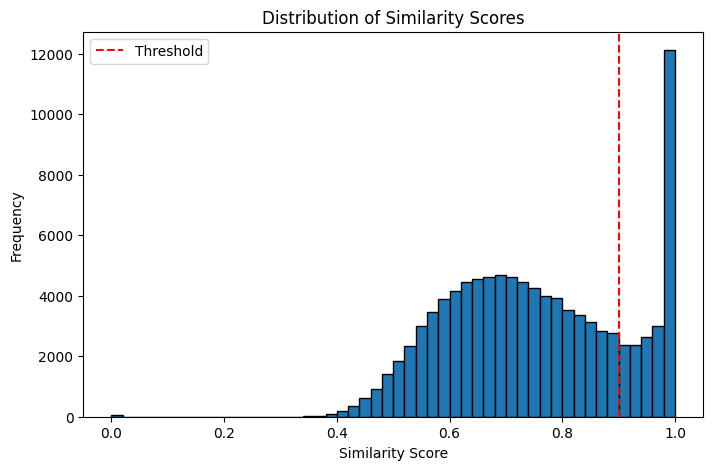

In [ ]:
import matplotlib.pyplot as plt

# Plot similarity score distribution
plt.figure(figsize=(8, 5))
plt.hist(distances[:, 1], bins=50, edgecolor='black')
plt.axvline(x=similarity_threshold, color='red', linestyle='--', label="Threshold")
plt.title("Distribution of Similarity Scores")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

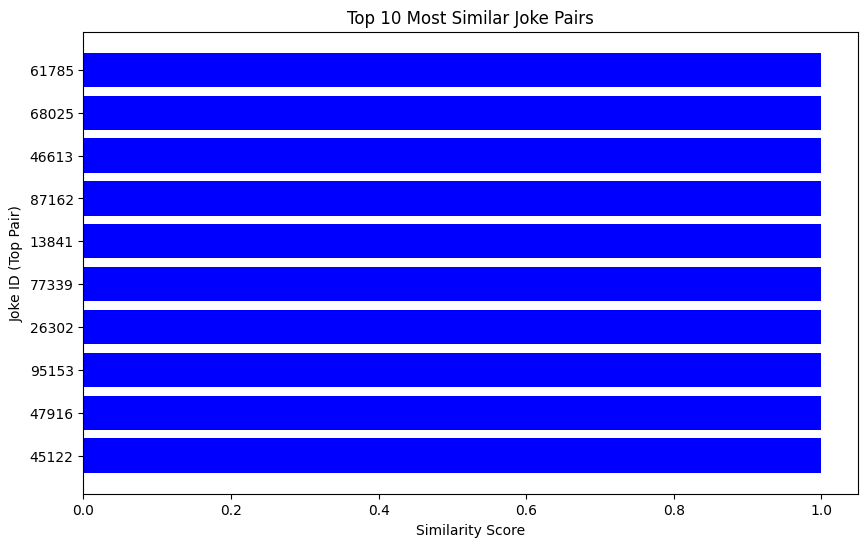

In [ ]:
top_pairs = high_similarity_pairs.sort_values(by="Similarity_Score", ascending=False).head(10)

# Plot the top similarity scores
plt.figure(figsize=(10, 6))
plt.barh(top_pairs['Joke_ID'].astype(str), top_pairs['Similarity_Score'], color='blue')
plt.title("Top 10 Most Similar Joke Pairs")
plt.xlabel("Similarity Score")
plt.ylabel("Joke ID (Top Pair)")
plt.gca().invert_yaxis()  # Invert for better readability
plt.show()


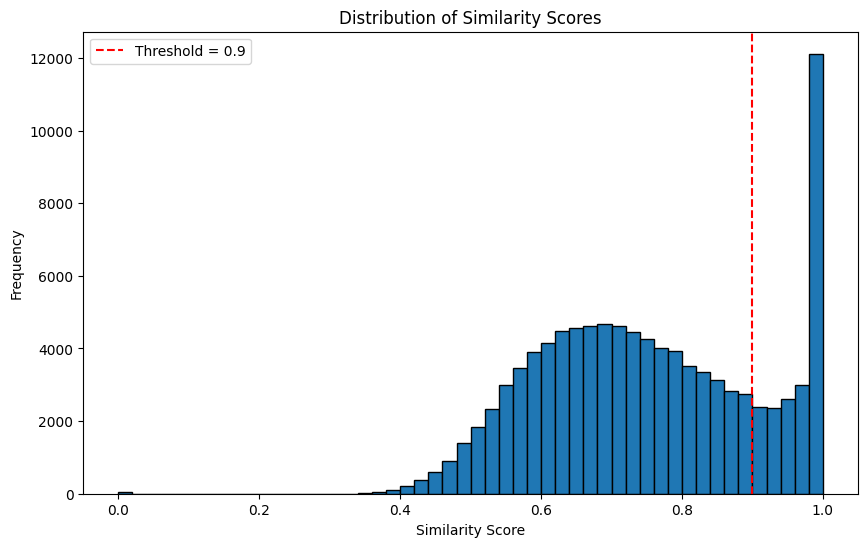

In [ ]:
# Plot similarity score distribution
plt.figure(figsize=(10, 6))
plt.hist(similarity_df['Similarity_Score'], bins=50, edgecolor='black')
plt.axvline(x=similarity_threshold, color='red', linestyle='--', label="Threshold = 0.9")
plt.title("Distribution of Similarity Scores")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()


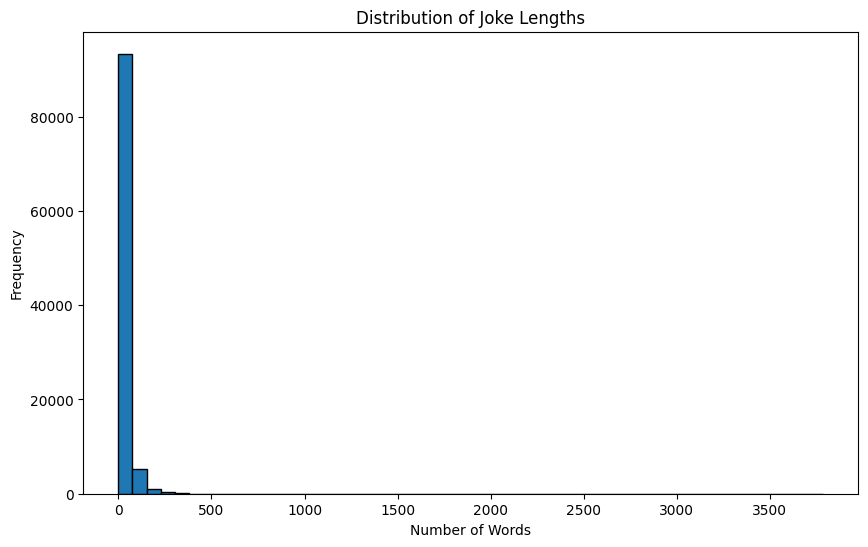

In [ ]:
import matplotlib.pyplot as plt

# Calculate the word count for each joke
df_sampled['joke_length'] = df_sampled['processed_text'].apply(lambda x: len(x.split()))

# Plot the distribution of joke lengths
plt.figure(figsize=(10, 6))
plt.hist(df_sampled['joke_length'], bins=50, edgecolor='black')
plt.title("Distribution of Joke Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

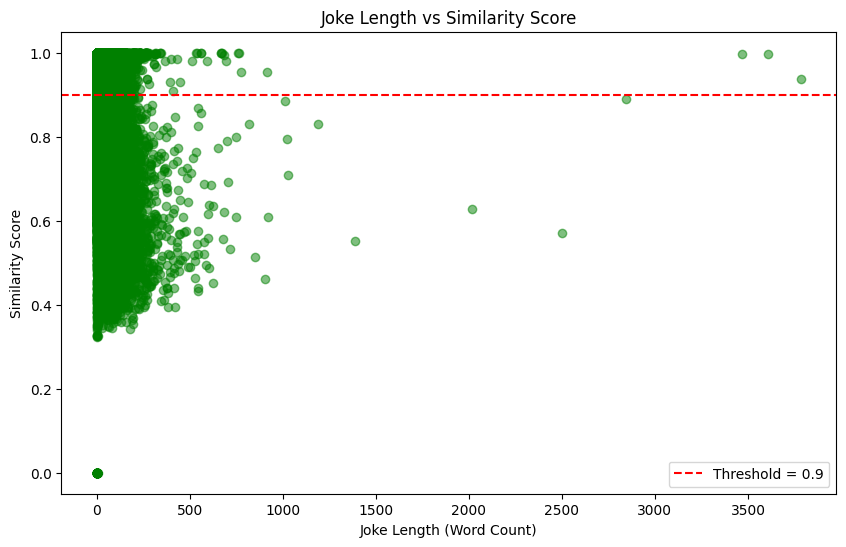

In [ ]:
# Merge joke lengths with similarity data
similarity_df['Joke_Length'] = similarity_df['Joke_ID'].apply(lambda x: df_sampled.iloc[x]['joke_length'])

# Plot length vs similarity
plt.figure(figsize=(10, 6))
plt.scatter(similarity_df['Joke_Length'], similarity_df['Similarity_Score'], alpha=0.5, color='green')
plt.axhline(y=similarity_threshold, color='red', linestyle='--', label="Threshold = 0.9")
plt.title("Joke Length vs Similarity Score")
plt.xlabel("Joke Length (Word Count)")
plt.ylabel("Similarity Score")
plt.legend()
plt.show()

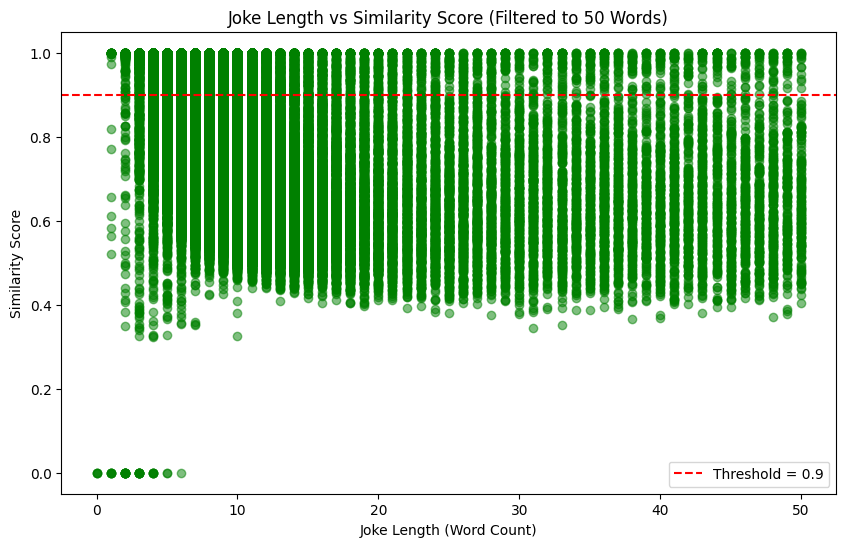

In [ ]:
# Filter the DataFrame to include only jokes with lengths up to 50 words
filtered_similarity_df = similarity_df[similarity_df['Joke_Length'] <= 50]

# Plot length vs similarity for filtered data
plt.figure(figsize=(10, 6))
plt.scatter(filtered_similarity_df['Joke_Length'], filtered_similarity_df['Similarity_Score'], alpha=0.5, color='green')
plt.axhline(y=similarity_threshold, color='red', linestyle='--', label="Threshold = 0.9")
plt.title("Joke Length vs Similarity Score (Filtered to 50 Words)")
plt.xlabel("Joke Length (Word Count)")
plt.ylabel("Similarity Score")
plt.legend()
plt.show()

In [ ]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words]
    # Join words back together
    return ' '.join(words)

df_filtered['clean_joke_text'] = df_filtered['joke_text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df_filtered['clean_joke_text'].head(10)

,clean_joke_text
0,soooo glad im circumcised corona covered fores...
1,know google platform recording bowel movements...
2,difference wife vacuum vacuum doesnt snore sex...
3,french man say attractive teletubby oolala
4,yo mama yo mommas fat went zoo hippos got jealous
5,pilot turn plane pens pencils ruler refuel nee...
6,th birthday friend introduced fit sister happy...
7,animal softest bite gummy bears
8,april fool nothing funny april fools day cance...
9,want know user gullible click find


In [ ]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 558509 entries, 0 to 561549
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   selftext        558508 non-null  object 
 1   title           558509 non-null  object 
 2   score           558509 non-null  float64
 3   created_utc     558509 non-null  float64
 4   joke_text       558509 non-null  object 
 5   language        558509 non-null  object 
 6   clean_text      558509 non-null  object 
 7   processed_text  558509 non-null  object 
dtypes: float64(2), object(6)
memory usage: 38.3+ MB


In [ ]:
df_filtered.to_csv('df_filtered_latest.csv', index=False)

In [ ]:
import pandas as pd

# Load the DataFrame
df_filtered = pd.read_csv('df_filtered_latest.csv')

# Now you can work with the DataFrame
print(df_filtered.head())


                                            selftext  \
0  My corona is covered with foreskin so it is no...   
1                         It's called Google Sheets.   
2  The vacuum doesn't snore after sex.\n\n&amp;#x...   
3                                        Oo..lala...   
4  Yo momma's so fat, that when she went to the z...   

                                               title  score   created_utc  \
0               I am soooo glad I'm not circumcised!    2.0  1.585786e+09   
1  Did you know Google now has a platform for rec...    9.0  1.585786e+09   
2  What is the difference between my wife and my ...   15.0  1.585786e+09   
3  What did the French man say to the attractive ...    2.0  1.585784e+09   
4                                            Yo Mama    0.0  1.585784e+09   

                                           joke_text language  \
0  I am soooo glad I'm not circumcised! My corona...       en   
1  Did you know Google now has a platform for rec...       en   
2  Wh

In [ ]:
print(df_filtered.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558509 entries, 0 to 558508
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   selftext        558508 non-null  object 
 1   title           558509 non-null  object 
 2   score           558509 non-null  float64
 3   created_utc     558509 non-null  float64
 4   joke_text       558509 non-null  object 
 5   language        558509 non-null  object 
 6   clean_text      558508 non-null  object 
 7   processed_text  558498 non-null  object 
dtypes: float64(2), object(6)
memory usage: 34.1+ MB
None


In [ ]:
# 1. Setup and Imports
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# 2. Device Configuration
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 3. Initialize Tokenizer and Model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.to(device)
model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
# 4. Embedding Generation Function (Batch Processing)
def get_bert_embeddings(texts, batch_size=32):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating BERT Embeddings"):
        # Convert the batch to a list of strings, handling potential NaN values
        batch_texts = texts[i:i + batch_size].astype(str).tolist()
        # Tokenize batch
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        # Extract [CLS] embeddings
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(cls_embeddings)
    return np.vstack(embeddings)

# 5. Load and Sample Data
# Assuming df_filtered is already loaded
df_sample = df_filtered.sample(n=100000, random_state=42).reset_index(drop=True)

# 6. Generate Embeddings
batch_size = 32  # Adjust based on GPU memory
X = get_bert_embeddings(df_sample['processed_text'], batch_size=batch_size)
print(f"Embeddings shape: {X.shape}")

Generating BERT Embeddings: 100%|██████████| 3125/3125 [16:59<00:00,  3.06it/s]


Embeddings shape: (100000, 768)


In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
from tqdm import tqdm

# Initialize the Sentence Transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')
model.to(device)

# Function to generate embeddings in batches
def generate_embeddings(sentences, batch_size=1000):
    embeddings = []
    for i in tqdm(range(0, len(sentences), batch_size), desc="Generating Embeddings"):
        batch = sentences[i:i+batch_size].tolist()
        batch_embeddings = model.encode(batch, show_progress_bar=False, device=device)
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

# Generate embeddings
X = generate_embeddings(df_sample['processed_text'], batch_size=1000)
print(f"Embeddings shape: {X.shape}")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating Embeddings: 100%|██████████| 100/100 [00:49<00:00,  2.02it/s]

Embeddings shape: (100000, 384)


In [ ]:
from sklearn.decomposition import PCA

# Initialize PCA with more components
pca = PCA(n_components=100, random_state=42)
X_pca = pca.fit_transform(X)
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Total explained variance by 100 components: {explained_variance:.2%}")


Total explained variance by 100 components: 68.54%


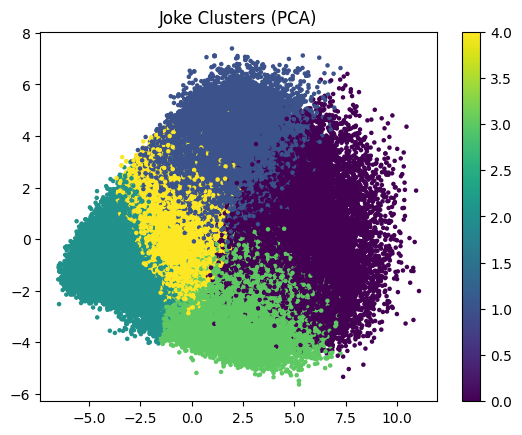

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions with PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# Plot the clusters
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', s=5)
plt.colorbar()
plt.title('Joke Clusters (PCA)')
plt.show()

In [ ]:
# 8. Clustering with MiniBatch K-Means
n_clusters = 5
kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=10000, random_state=42)
print("Clustering with MiniBatch K-Means...")
kmeans.fit(X_pca)
df_sample['cluster'] = kmeans.labels_
print(df_sample['cluster'].value_counts())

# 9. Cluster Analysis
def display_cluster_samples(df, cluster_col='cluster', text_col='joke_text', num_samples=5):
    for cluster in sorted(df[cluster_col].unique()):
        print(f"\nCluster {cluster}:")
        sample_jokes = df[df[cluster_col] == cluster][text_col].sample(n=num_samples, random_state=42)
        for idx, joke in enumerate(sample_jokes, 1):
            print(f"{idx}. {joke}")

# Display sample jokes from each cluster
display_cluster_samples(df_sample)

Clustering with MiniBatch K-Means...
cluster
3    29066
1    22829
0    19497
4    15149
2    13459
Name: count, dtype: int64

Cluster 0:
1. Planning on wearing a slutty costume for Halloween? Dress up as my professors, they barely cover anything important. 
2. Why is a divorce so expensive? It’s worth it. 
3. Tonight i got drunk and fucked my girlfriend the same way i did before we were dating. I didnt fuck her. 
4. Why was the bike on the bed? Because it was, two tired.
5. The relationship is over when she says those 3 little words. "God did it."

Cluster 1:
1. What kind of bombs is Kim Jong-Un developing? Unclear.
2. And coming up on BBC Two... The former leader of Nazi Germany traces back his family history in *Who Do You Think You Are Kidding, Mr Hitler?*
3. The first standalone Star Wars movie sucked [No Rogue one spoilers] Setting the plot around saving Jabbas baby, what where they thinking.
4. With all these Trump and Hillary signs in front of everyone's houses... This Hallowee

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.5 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


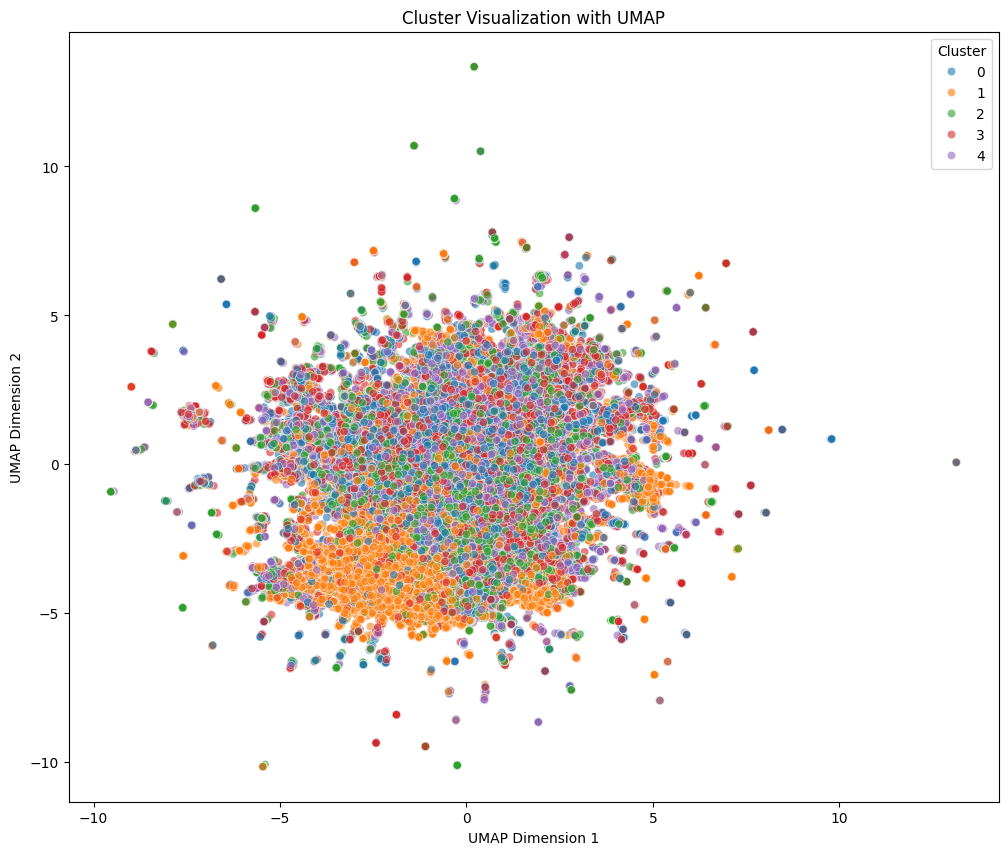

In [ ]:


!pip install umap-learn # Install umap-learn

import umap # Now you can import umap
import seaborn as sns
import umap
import seaborn as sns

# Initialize UMAP reducer
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_pca)

# Create a DataFrame for visualization
vis_df = pd.DataFrame({
    'x': X_umap[:,0],
    'y': X_umap[:,1],
    'cluster': df_sample['cluster']
})

# Plot the clusters
plt.figure(figsize=(12, 10))
sns.scatterplot(data=vis_df, x='x', y='y', hue='cluster', palette='tab10', alpha=0.6)
plt.title('Cluster Visualization with UMAP')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Cluster')
plt.show()


In [ ]:
import torch

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [ ]:
# Install transformers library
!pip install transformers

In [ ]:
df_sample = df_filtered.sample(n=10000, random_state=3)

# 1st Attempt

In [ ]:
sample_size = 10000
rng = np.random.default_rng(seed=42)  # For reproducibility
sample_indices = rng.choice(X.shape[0], size=sample_size, replace=False)
X_sample = X[sample_indices]
labels_sample = labels[sample_indices]

In [ ]:

# Assuming df_filtered is already defined as in the provided code.
df_filtered.to_csv('df_filtered_with_clusters.csv', index=False)

In [ ]:
# prompt: read df_filtered_with_clusters.csv

import pandas as pd

df_filtered = pd.read_csv('df_filtered_with_clusters.csv')
print(df_filtered.head())

                                            selftext  \
0  My corona is covered with foreskin so it is no...   
1                         It's called Google Sheets.   
2  The vacuum doesn't snore after sex.\n\n&amp;#x...   
3                                        Oo..lala...   
4  Yo momma's so fat, that when she went to the z...   

                                               title  score   created_utc  \
0               I am soooo glad I'm not circumcised!    2.0  1.585786e+09   
1  Did you know Google now has a platform for rec...    9.0  1.585786e+09   
2  What is the difference between my wife and my ...   15.0  1.585786e+09   
3  What did the French man say to the attractive ...    2.0  1.585784e+09   
4                                            Yo Mama    0.0  1.585784e+09   

                                           joke_text language  \
0  I am soooo glad I'm not circumcised! My corona...       en   
1  Did you know Google now has a platform for rec...       en   
2  Wh

In [ ]:
print("Sampling data for visualization...")
sample_size = 10000
df_sample = df_filtered.sample(n=sample_size, random_state=42).reset_index(drop=True)
X_sample = X[df_sample.index]  # Corresponding embeddings
print(f"Sampled {len(df_sample)} rows for visualization.")

Sampling data for visualization...
Sampled 10000 rows for visualization.


In [ ]:
!pip install umap-learn
!pip install umap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3542 sha256=58ac824700f256276a058ea3f903a12b631b18b7cf5dd3bab7ca325da03df087
  Stored in directory: /root/.cache/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
Successfully built umap


In [ ]:
import numpy as np
from tqdm import tqdm
import torch
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting
from math import pi

print("Standardizing sampled embeddings...")
scaler = StandardScaler()
X_sample_scaled = scaler.fit_transform(X_sample)

Standardizing sampled embeddings...


In [ ]:
# b. Perform PCA to reduce dimensions to 50 (optional but recommended)
print("Performing PCA reduction to 50 dimensions...")
pca_50 = PCA(n_components=50, random_state=42)
X_pca_50 = pca_50.fit_transform(X_sample_scaled)
print(f"PCA reduced shape: {X_pca_50.shape}")

Performing PCA reduction to 50 dimensions...
PCA reduced shape: (10000, 50)


In [ ]:
# c. Reduce further to 2D for PCA visualization
print("Reducing dimensions to 2D using PCA for visualization...")
pca_visual = PCA(n_components=2, random_state=42)
X_pca_vis = pca_visual.fit_transform(X_pca_50)
df_sample['PCA1'] = X_pca_vis[:, 0]
df_sample['PCA2'] = X_pca_vis[:, 1]


Reducing dimensions to 2D using PCA for visualization...


In [ ]:
# d. Apply UMAP to sampled data
import umap.umap_ as umap
print("Applying UMAP to sampled data...")
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap_sample = umap_reducer.fit_transform(X_sample_scaled)
df_sample['UMAP1'] = X_umap_sample[:, 0]
df_sample['UMAP2'] = X_umap_sample[:, 1]

Applying UMAP to sampled data...


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
# e. Apply t-SNE to sampled data
print("Applying t-SNE to sampled data...")
tsne = TSNE(
    n_components=2,
    perplexity=30,        # Adjust based on data characteristics
    learning_rate=200,    # Default is 200
    n_iter=1000,          # Number of iterations
    random_state=42,
    verbose=1
)
X_tsne = tsne.fit_transform(X_pca_50)  # Using PCA-reduced data for efficiency
df_sample['tSNE1'] = X_tsne[:, 0]
df_sample['tSNE2'] = X_tsne[:, 1]
print("t-SNE transformation completed.")

Applying t-SNE to sampled data...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 10000 samples in 1.921s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 5.418035
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.083382
[t-SNE] KL divergence after 1000 iterations: 2.909203
t-SNE transformation completed.


Creating visualizations...


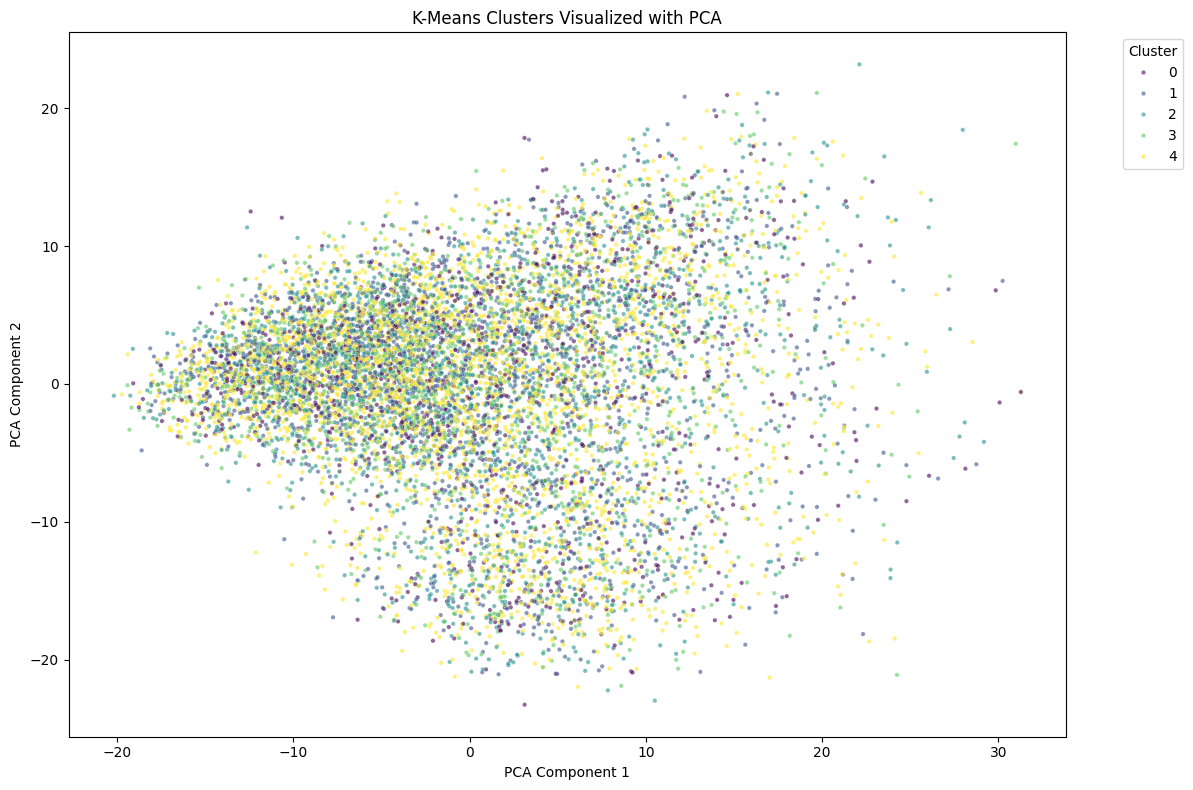

In [ ]:
print("Creating visualizations...")

# a. PCA Scatter Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PCA1',
    y='PCA2',
    hue='cluster',
    data=df_sample,
    palette='viridis',
    s=10,
    alpha=0.6
)
plt.title('K-Means Clusters Visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


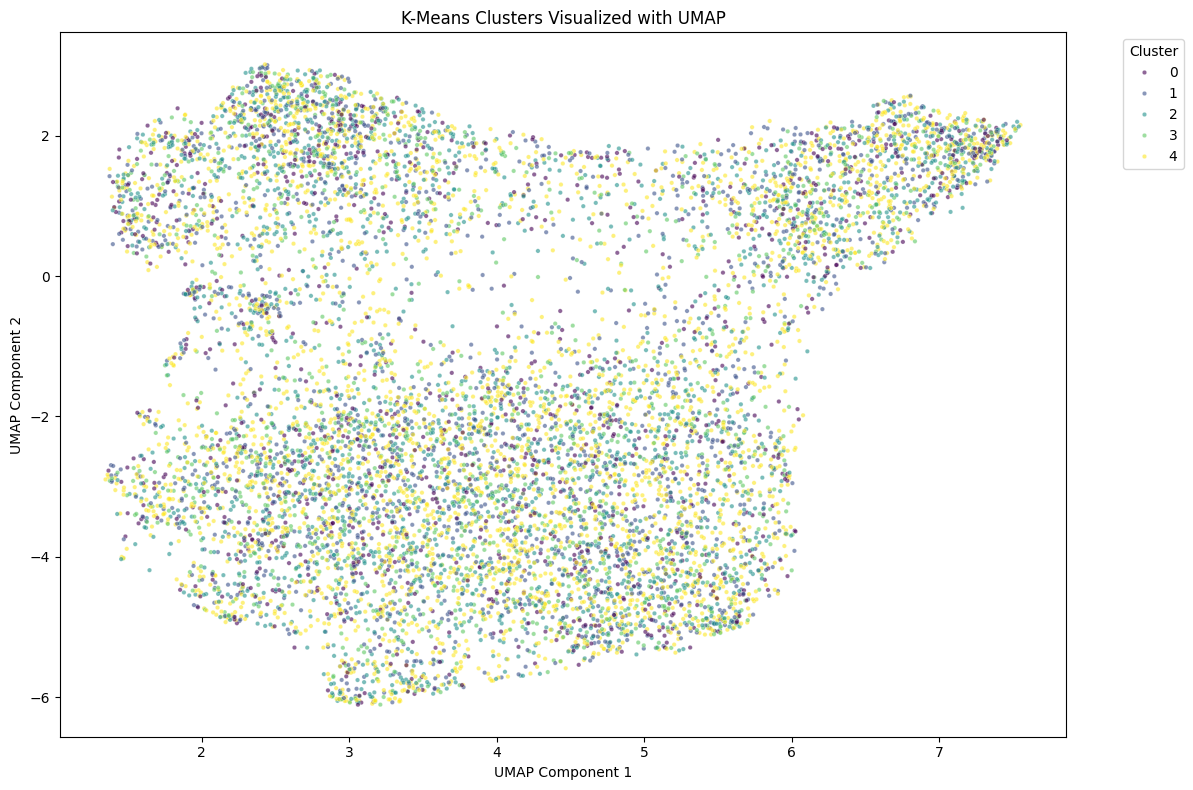

In [ ]:
# b. UMAP Scatter Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='UMAP1',
    y='UMAP2',
    hue='cluster',
    data=df_sample,
    palette='viridis',
    s=10,
    alpha=0.6
)
plt.title('K-Means Clusters Visualized with UMAP')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

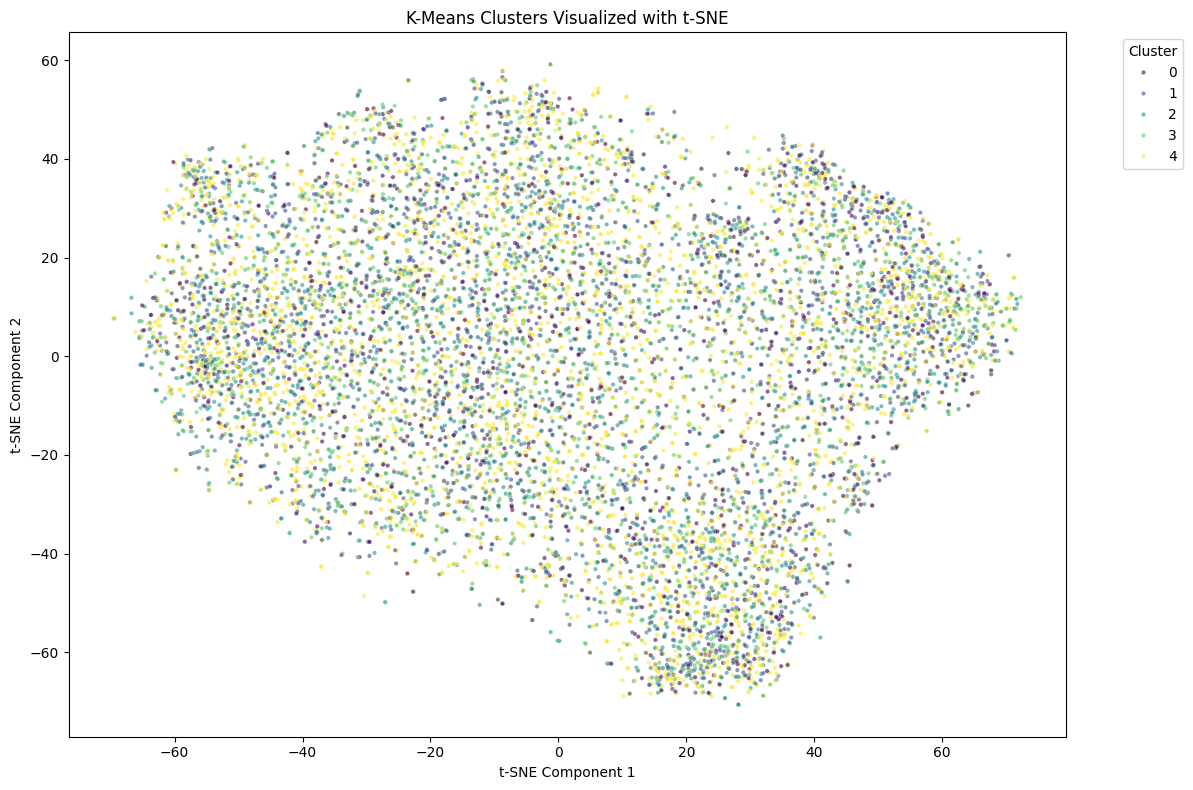

In [ ]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='tSNE1',
    y='tSNE2',
    hue='cluster',
    data=df_sample,
    palette='viridis',
    s=10,
    alpha=0.6
)
plt.title('K-Means Clusters Visualized with t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

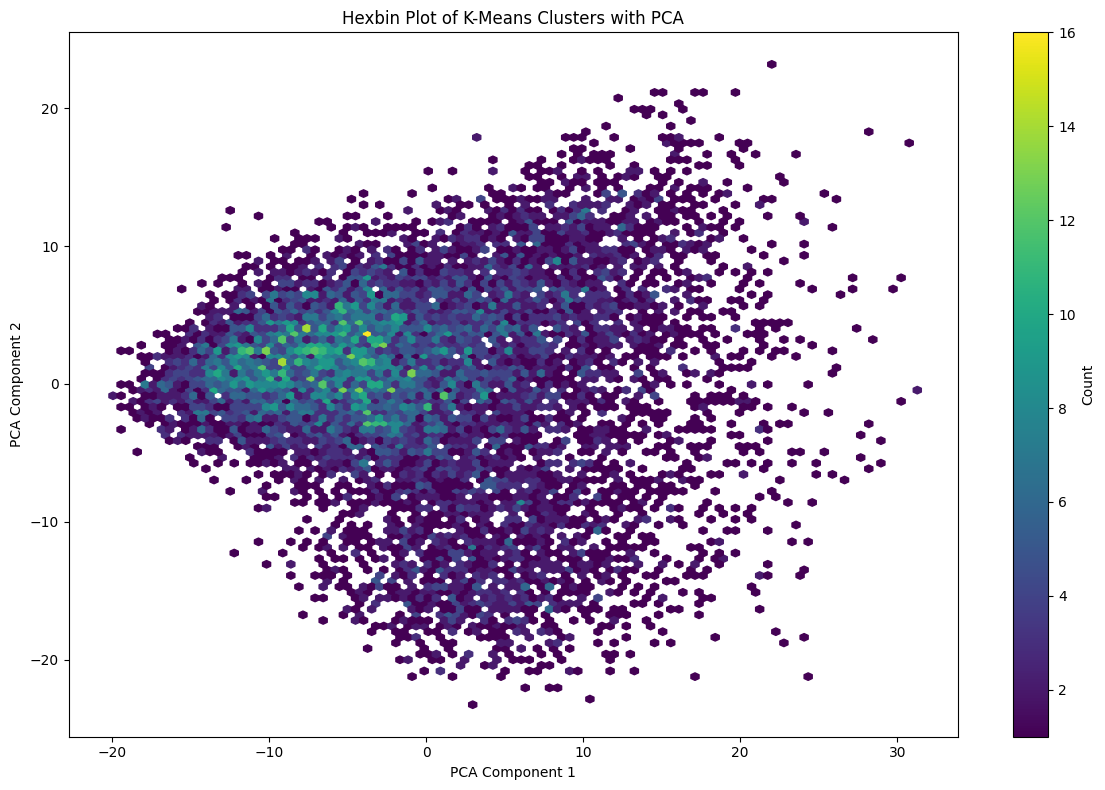

In [ ]:
# d. Hexbin Plot with PCA
plt.figure(figsize=(12, 8))
plt.hexbin(df_sample['PCA1'], df_sample['PCA2'], gridsize=100, cmap='viridis', mincnt=1)
plt.colorbar(label='Count')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Hexbin Plot of K-Means Clusters with PCA')
plt.tight_layout()
plt.show()